# **install**

In [ ]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 87.3 MB/s 


In [ ]:
!pip install ptan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.5 kB/s 
  Created wheel for ptan: filename=ptan-0.7-py3-none-any.whl size=23505 sha256=7826fb4d0f93efb134a564ccaf79a210e5b57233a1e0140258d20c2890901936
  Stored in directory: /root/.cache/pip/wheels/60/72/3d/a3c47193fdb9efd08e3a54398af996b2989c68571813a71256
Successfully built ptan
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torc

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


# **explore**

In [ ]:
import gym
import pybullet_envs

env = gym.make("MinitaurBulletEnv-v0")

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(720, 960, 3)


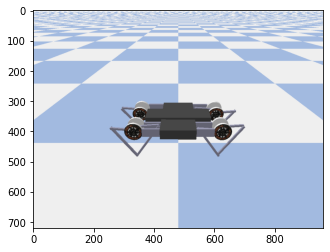

In [ ]:
xxx = env.render('rgb_array')
print(xxx.shape)

import matplotlib.pyplot as plt
plt.imshow(xxx)

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()
  action = env.action_space.sample()
  _, _, done, info = env.step(action)

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

Output hidden; open in https://colab.research.google.com to view.

# **model**

In [ ]:
import ptan
import numpy as np
import torch
import torch.nn as nn

HID_SIZE = 64


class ModelActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelActor, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),    ####
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),    ####
            nn.Linear(HID_SIZE, act_size),
            nn.Tanh(),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(x)


class ModelCritic(nn.Module):
    def __init__(self, obs_size):
        super(ModelCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, x):
        return self.value(x)


class ModelSACTwinQ(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelSACTwinQ, self).__init__()

        self.q1 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

        self.q2 = nn.Sequential(
            nn.Linear(obs_size + act_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=1)
        return self.q1(x), self.q2(x)


class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        logstd = self.net.logstd.data.cpu().numpy()
        rnd = np.random.normal(size=logstd.shape)
        actions = mu + np.exp(logstd) * rnd
        actions = np.clip(actions, -1, 1)
        return actions, agent_states


class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True,
                 ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2,
                 ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()

        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(
                        shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(
                    size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states

        actions = np.clip(actions, -1, 1)
        return actions, new_a_states

# **import & define**

In [ ]:
# cuda or not
import torch

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [ ]:
import os
import math
import ptan
import time
import gym
import pybullet_envs
# import argparse
from tensorboardX import SummaryWriter

# from lib import model, test_net, calc_logprob

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F


ENV_ID = "MinitaurBulletEnv-v0"
GAMMA = 0.99
GAE_LAMBDA = 0.95

TRAJECTORY_SIZE = 2049 ########
LEARNING_RATE_ACTOR = 1e-5
LEARNING_RATE_CRITIC = 1e-4

PPO_EPS = 0.2
PPO_EPOCHES = 10 ########
PPO_BATCH_SIZE = 64 ########

TEST_ITERS = 100000

def calc_adv_ref(trajectory, net_crt, states_v, device="cpu"):
    """
    By trajectory calculate advantage and 1-step ref value
    :param trajectory: trajectory list
    :param net_crt: critic network
    :param states_v: states tensor
    :return: tuple with advantage numpy array and reference values
    """
    values_v = net_crt(states_v)
    values = values_v.squeeze().data.cpu().numpy()
    # generalized advantage estimator: smoothed version of the advantage
    last_gae = 0.0
    result_adv = []
    result_ref = []
    for val, next_val, (exp,) in zip(reversed(values[:-1]),
                                     reversed(values[1:]),
                                     reversed(trajectory[:-1])):
        if exp.done:
            delta = exp.reward - val
            last_gae = delta
        else:
            delta = exp.reward + GAMMA * next_val - val
            last_gae = delta + GAMMA * GAE_LAMBDA * last_gae
        result_adv.append(last_gae)
        result_ref.append(delta + val)

    adv_v = torch.FloatTensor(list(reversed(result_adv)))
    ref_v = torch.FloatTensor(list(reversed(result_ref)))
    return adv_v.to(device), ref_v.to(device)


def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)

            mu_v = net(obs_v)
            mu = mu_v.data.cpu().numpy().squeeze()
            actions = np.clip(mu, -1, 1)

            obs, reward, done, _ = env.step(actions)

            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count


def calc_logprob(mu_v, logstd, actions_v):
    var_v = torch.exp(2*logstd)
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * math.pi * var_v.clamp(min=1e-3)))
    return p1 + p2


In [ ]:
# setup

save_path = os.path.join('mount/My Drive/Colab Notebooks/minitaur_', '03_22060201_PPO')
os.makedirs(save_path, exist_ok=True)

env = gym.make(ENV_ID)
test_env = gym.make(ENV_ID)

net_act = ModelActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
net_crt = ModelCritic(env.observation_space.shape[0]).to(device)
print(net_act)
print(net_crt)

writer = SummaryWriter(comment="-ppo_")
agent = AgentA2C(net_act, device=device)
exp_source = ptan.experience.ExperienceSource(env, agent, steps_count=1)

opt_act = optim.Adam(net_act.parameters(), lr=LEARNING_RATE_ACTOR)
opt_crt = optim.Adam(net_crt.parameters(), LEARNING_RATE_CRITIC)

current_dir=/usr/local/lib/python3.7/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


ModelActor(
  (mu): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
  )
)
ModelCritic(
  (value): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


# **train**

In [ ]:
trajectory = []
best_reward = None

In [ ]:
with ptan.common.utils.RewardTracker(writer) as tracker:
    for step_idx, exp in enumerate(exp_source):
        rewards_steps = exp_source.pop_rewards_steps()
        if rewards_steps:
            rewards, steps = zip(*rewards_steps)
            writer.add_scalar("episode_steps", np.mean(steps), step_idx)
            tracker.reward(np.mean(rewards), step_idx)

        if step_idx % TEST_ITERS == 0:
            ts = time.time()
            rewards, steps = test_net(net_act, test_env, device=device)
            print("Test done in %.2f sec, reward %.3f, steps %d" % (
                time.time() - ts, rewards, steps))
            writer.add_scalar("test_reward", rewards, step_idx)
            writer.add_scalar("test_steps", steps, step_idx)
            if best_reward is None or best_reward < rewards:
                if best_reward is not None:
                    print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                    name = "best_%+.3f_%d.dat" % (rewards, step_idx)
                    fname = os.path.join(save_path, name)
                    torch.save(net_act.state_dict(), fname)
                best_reward = rewards

        trajectory.append(exp)
        if len(trajectory) < TRAJECTORY_SIZE:
            continue

        traj_states = [t[0].state for t in trajectory]
        traj_actions = [t[0].action for t in trajectory]
        traj_states_v = torch.FloatTensor(traj_states)
        traj_states_v = traj_states_v.to(device)
        traj_actions_v = torch.FloatTensor(traj_actions)
        traj_actions_v = traj_actions_v.to(device)
        traj_adv_v, traj_ref_v = calc_adv_ref(
            trajectory, net_crt, traj_states_v, device=device)
        mu_v = net_act(traj_states_v)
        old_logprob_v = calc_logprob(
            mu_v, net_act.logstd, traj_actions_v)

        # normalize advantages
        traj_adv_v = traj_adv_v - torch.mean(traj_adv_v)
        traj_adv_v /= torch.std(traj_adv_v)

        # drop last entry from the trajectory, an our adv and ref value calculated without it
        trajectory = trajectory[:-1]
        old_logprob_v = old_logprob_v[:-1].detach()
        # traj_states_v = traj_states_v[:-1]
        # traj_actions_v = traj_actions_v[:-1]

        sum_loss_value = 0.0
        sum_loss_policy = 0.0
        count_steps = 0

        for epoch in range(PPO_EPOCHES):
            for batch_ofs in range(0, len(trajectory),
                                    PPO_BATCH_SIZE):
                batch_l = batch_ofs + PPO_BATCH_SIZE
                states_v = traj_states_v[batch_ofs:batch_l]
                actions_v = traj_actions_v[batch_ofs:batch_l]
                batch_adv_v = traj_adv_v[batch_ofs:batch_l]
                batch_adv_v = batch_adv_v.unsqueeze(-1)
                batch_ref_v = traj_ref_v[batch_ofs:batch_l]
                batch_old_logprob_v = \
                    old_logprob_v[batch_ofs:batch_l]

                # critic training
                opt_crt.zero_grad()
                value_v = net_crt(states_v)
                loss_value_v = F.mse_loss(
                    value_v.squeeze(-1), batch_ref_v)
                loss_value_v.backward()
                opt_crt.step()

                # actor training
                opt_act.zero_grad()
                mu_v = net_act(states_v)
                logprob_pi_v = calc_logprob(
                    mu_v, net_act.logstd, actions_v)
                ratio_v = torch.exp(
                    logprob_pi_v - batch_old_logprob_v)
                surr_obj_v = batch_adv_v * ratio_v
                c_ratio_v = torch.clamp(ratio_v,
                                        1.0 - PPO_EPS,
                                        1.0 + PPO_EPS)
                clipped_surr_v = batch_adv_v * c_ratio_v
                loss_policy_v = -torch.min(
                    surr_obj_v, clipped_surr_v).mean()
                loss_policy_v.backward()
                opt_act.step()

                sum_loss_value += loss_value_v.item()
                sum_loss_policy += loss_policy_v.item()
                count_steps += 1

        trajectory.clear()
        writer.add_scalar("advantage", traj_adv_v.mean().item(), step_idx)
        writer.add_scalar("values", traj_ref_v.mean().item(), step_idx)
        writer.add_scalar("loss_policy", sum_loss_policy / count_steps, step_idx)
        writer.add_scalar("loss_value", sum_loss_value / count_steps, step_idx)

流式输出内容被截断，只能显示最后 5000 行内容。
2740729: done 8618 episodes, mean reward 1.118, speed 167.90 f/s
2741059: done 8619 episodes, mean reward 1.107, speed 163.51 f/s
2741482: done 8621 episodes, mean reward 1.094, speed 167.96 f/s
2741885: done 8622 episodes, mean reward 1.089, speed 112.20 f/s
2742749: done 8624 episodes, mean reward 1.113, speed 172.68 f/s
2743683: done 8625 episodes, mean reward 1.141, speed 145.72 f/s
2744796: done 8627 episodes, mean reward 1.163, speed 169.05 f/s
2745241: done 8629 episodes, mean reward 1.138, speed 162.27 f/s
2746371: done 8631 episodes, mean reward 1.145, speed 147.22 f/s
2746871: done 8633 episodes, mean reward 1.136, speed 161.40 f/s
2747332: done 8634 episodes, mean reward 1.155, speed 183.08 f/s
2747516: done 8635 episodes, mean reward 1.158, speed 151.87 f/s
2747819: done 8636 episodes, mean reward 1.158, speed 98.37 f/s
2748035: done 8638 episodes, mean reward 1.146, speed 148.88 f/s
2748834: done 8640 episodes, mean reward 1.133, speed 166.86 f/s

KeyboardInterrupt: ignored

In [ ]:
torch.save(net_act.state_dict(), 'mount/My Drive/Colab Notebooks/minitaur_/03_22060201_PPO/net_act.pth')
torch.save(net_crt.state_dict(), 'mount/My Drive/Colab Notebooks/minitaur_/03_22060201_PPO/net_crt.pth')

# **episode**

In [ ]:
# video recorder import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# video -> html function
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/03_22060201_PPO/net_act.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# video record

minitaur_training = "minitaur_training.mp4"
video = VideoRecorder(env, minitaur_training)

steps = 0
rewards = 0

state = env.reset()
done = False
while not done:
  env.render()
  video.capture_frame()

  state = torch.tensor(state, dtype=torch.float)
  action = net(state)
  action = action.squeeze(dim=0).data.cpu().numpy()
  logstd = net.logstd.data.cpu().numpy()
  rnd = np.random.normal(size=logstd.shape)
  action = action + np.exp(logstd) * rnd
  action = np.clip(action, -1, 1)
  next_state, reward, done, info = env.step(action)

  state = next_state
  steps += 1
  rewards += reward

  pass

env.render()
video.capture_frame()

video.close()
env.close()

In [ ]:
print('steps:', steps)
print('rewards:', rewards)

steps: 986
rewards: 4.150735907808585


In [ ]:
# video play

from IPython.display import HTML
html = render_mp4(minitaur_training)
HTML(html)

Output hidden; open in https://colab.research.google.com to view.

# **Assess**

In [ ]:
# setup env & download model

env = gym.make("MinitaurBulletEnv-v0")

net = ModelActor(env.observation_space.shape[0], env.action_space.shape[0])
net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/minitaur_/03_22060201_PPO/net_act.pth'))

urdf_root=/usr/local/lib/python3.7/dist-packages/pybullet_data


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<All keys matched successfully>

In [ ]:
# simulate

rewords_by_episodes = []
steps_by_episodes = []

for i in range(100):
  
  rewords = 0
  steps = 0

  state = env.reset()
  done = False
  while not done:

    state = torch.tensor(state, dtype=torch.float)
    action = net(state)
    action = action.squeeze(dim=0).data.cpu().numpy()
    logstd = net.logstd.data.cpu().numpy()
    rnd = np.random.normal(size=logstd.shape)
    action = action + np.exp(logstd) * rnd
    action = np.clip(action, -1, 1)
    next_state, reword, done, info = env.step(action)

    state = next_state
    rewords += reword
    steps += 1

    pass

  rewords_by_episodes.append(rewords)
  steps_by_episodes.append(steps)

  pass

env.close()

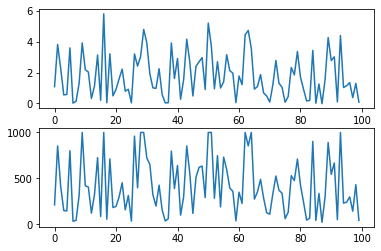

In [ ]:
# plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].plot(rewords_by_episodes)
ax[1].plot(steps_by_episodes)